# Notebook 3 - Comparing RGB values to RGB composite loop.

To better understand what RGB thresholds compare to specific types of clouds, we can plot their values next to the composite map.

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import imageio

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

warnings.filterwarnings("ignore", message="Engine 'cfgrib' loading failed:")

#### Using different version of the `plot_rgb_image` function because we're adding another pannel to the plot

In [27]:
# Function to generate the time string based on date and time of day
def generate_time(date, time_of_day):
    # Convert date string to datetime object
    date_obj = datetime.strptime(date, '%Y%m%d')
    # Format the date part
    date_str = date_obj.strftime('%Y-%m-%d')
    # Combine date and time of day
    time_str = f'{date_str}T{time_of_day}'
    return time_str

def plot_rgb_image_and_timeseries(ds, timeseries_ds, date, time_of_day, gif=False):
    """""
    Plot RGB image from xarray dataset and save as PNG.
    Parameters:
    ds (xarray.Dataset): The dataset containing the RGB channels.
    timeseries_ds (xarray.Dataset): The dataset containing the timeseries data for the RGB channels.
    date (str): The date in 'YYYYMMDD' format.
    time_of_day (str): The time of day in 'HH:MM:SS' format.
    gif (bool): Whether to save the plot as a GIF.
    """

    # Extract the values as NumPy arrays
    red = ds['red'].values
    green = ds['green'].values
    blue = ds['blue'].values

    # Find the minimum shape among the arrays
    min_shape = np.min([red.shape, green.shape, blue.shape], axis=0)

    # Resize the arrays to the minimum shape
    red_resized = red[:min_shape[0], :min_shape[1]]
    green_resized = green[:min_shape[0], :min_shape[1]]
    blue_resized = blue[:min_shape[0], :min_shape[1]]

    # Ensure the arrays have the same dimensions
    assert red_resized.shape == green_resized.shape == blue_resized.shape, "Arrays must have the same shape"

    # Stack the arrays along the last dimension to create an RGB image
    rgb_image = np.stack([red_resized, green_resized, blue_resized], axis=-1)

    # Extract longitude and latitude values
    lon = ds['longitude'].values
    lat = ds['latitude'].values

    # Plot the RGB image using matplotlib's imshow
    fig, ax = plt.subplots(2,1,figsize=(10, 10))

    # Plot the RGB image
    rgb_plot = ax[0].imshow(rgb_image, extent=[lon.min(), lon.max(), lat.min(), lat.max()])
    ax[0].set_xlabel('Longitude')
    ax[0].set_ylabel('Latitude')
    ax[0].set_title('GOES Day Cloud Phase RGB Composite - ' + date + ' ' + str(time_of_day) + ' UTC')
    ax[0].axis('on')  # Show the axis

    # Select and plot the timeseries of the RGB channels for the pixel defined
    # 48.464462 lat	-122.959918 lon
    pixel_lat = 48.464462
    pixel_lon = -122.959918
    selected_pixel = timeseries_ds.sel(longitude=pixel_lon, latitude=pixel_lat, method="nearest")
    ax[0].plot(selected_pixel.longitude, selected_pixel.latitude, 'ro', markersize=5, label='Northern Site Camera')
    ax[0].legend()
    
    
    ax[1].plot(selected_pixel.t, selected_pixel.red, label='Red Channel', color='red', alpha=0.5)
    ax[1].plot(selected_pixel.t, selected_pixel.green, label='Green Channel', color='green', alpha=0.5)
    ax[1].plot(selected_pixel.t, selected_pixel.blue, label='Blue Channel', color='blue', alpha=0.5)
    current_time = datetime.strptime(f"{date} {str(time_of_day)}", "%Y%m%d %H:%M:%S")
    ax[1].axvline(x=current_time, color='black', linestyle='--', label='selected time\nfor map above')
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('RGB Value')
    ax[1].set_title('Timeseries of RGB Channels at Jessica\'s camera (48.464462, -122.959918)')
    ax[1].legend()

    # # Convert the 't' coordinate to Python datetime objects
    # time_values = selected_pixel.t.values  # Extract the time coordinate
    # time_values = time_values.astype('datetime64[ms]').tolist()  # Convert to Python datetime
    # # Binary for cloud cover, 1 if green > 0.1, 0 otherwise
    # cloud_cover = (selected_pixel.green > 0.1).astype(int)
    # # Create a twin y-axis
    # ax2 = ax[1].twinx()
    # # Plot small bars at the top of the twin y-axis
    # for t, cloud in zip(time_values, cloud_cover):
    #     if cloud:  # If cloudy (cloud_cover == 1)
    #         ax2.axvline(t, color='gray', alpha=0.3, linewidth=3)  # Add a vertical gray bar
    # # Customize the twin y-axis
    # ax2.set_ylim(0, 1)  # Set y-axis limits for clarity
    # ax2.set_yticks([])  # Hide y-axis ticks
    # ax2.legend()
    # ax2.text(0.15, 0.8, 'Low clouds likely present (gray\nbars) when green>0.1\nie. higher albedo', 
    #          transform=ax2.transAxes, ha='center', va='bottom', fontsize=10, 
    #          bbox=dict(facecolor='white', alpha=0.5, edgecolor='k'))

    
    if gif:
        # Save the plot as a PNG file
        filename = f'./plots/goes_RGB_{date}_{time_of_day}.png'
        plt.savefig(filename)
        plt.close()
        return filename
    else:
        return rgb_plot
        plt.show()

def make_gif(ds, date):
    """
    Create a GIF from GOES data for a specific date and time range.

    Parameters:
    ds(xarray.Dataset): The dataset containing the GOES data.
    date (str): The date in 'YYYYMMDD' format.
    start_time (str): The start time in 'HHMM' format.
    end_time (str): The end time in 'HHMM' format.
    mask (bool): Whether to apply a cloud mask.
    """
    # input_file = f'/storage/cdalden/goes/goes16/RGB_composite/goes16_C02_C05_C13_RGB_colorado_{date}.nc'
    # ds = xr.open_dataset(input_file)


    start_time = datetime.strptime(f"{date}T000000", '%Y%m%dT%H%M%S')
    end_time = datetime.strptime(f"{date}T235500", '%Y%m%dT%H%M%S')

    ds = ds.sortby('t')

    # List to store the filenames of the generated plots
    filenames = []

    # Loop through every 10-minute chunk
    current_time = start_time
    while current_time <= end_time:
        time_str = current_time.strftime('%Y-%m-%dT%H:%M:%S')
        ds_i = ds.sel(t=time_str, method='nearest')
        hour_of_day = current_time.strftime('%H:%M')
        filename = plot_rgb_image_and_timeseries(ds_i, ds, date, current_time, gif=True)
        filenames.append(filename)
        current_time += timedelta(minutes=10)
        print(f'Generated RGB image for {time_str}')

    # Create the GIF
    start_time_out = start_time.strftime('%H%M')
    end_time_out =  end_time.strftime('%H%M')
    output_gif = f'./gifs/goes_RGB_{date}_{start_time_out}_{end_time_out}.gif'
    with imageio.get_writer(output_gif, mode='I', duration=0.5) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)

    # Clean up the temporary files
    import os
    for filename in filenames:
        os.remove(filename)
 

In [28]:
path = '/storage/cdalden/goes/washington/goes17/rgb_composite/'
file = 'goes17_C02_C05_C13_rgb_washington_20220801.nc'
ds = xr.open_dataset(path+file)


# Define the date and time of day
date = '20220801'
time_of_day = '14:55:00'
# make time monotonic increasing
ds = ds.sortby('t')

ds_i = ds.sel(t=time_of_day, method='nearest')

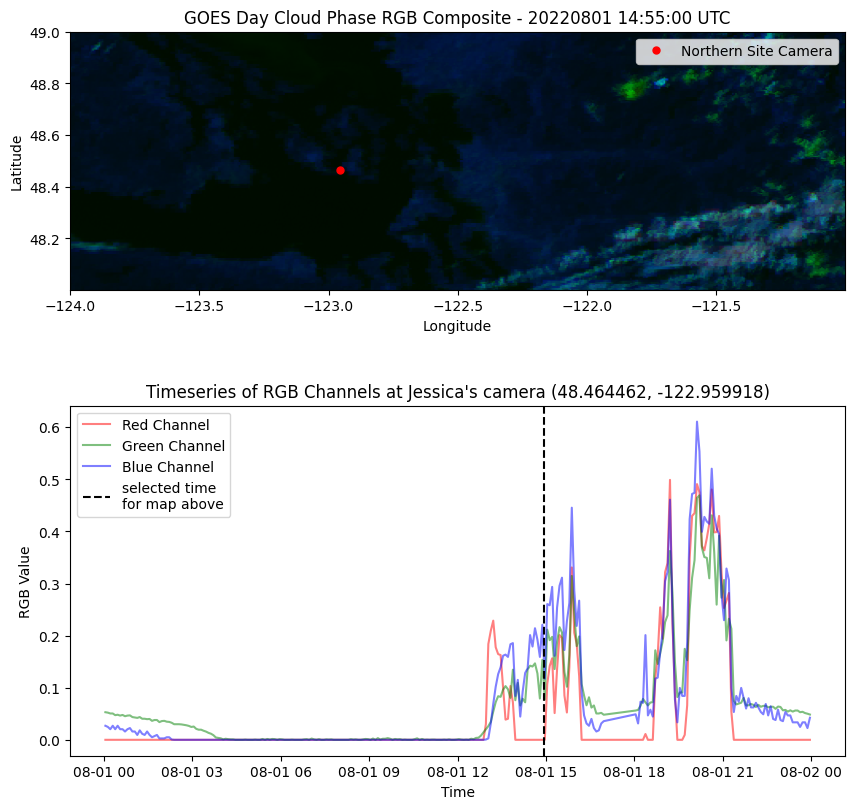

In [23]:
plot_rgb_image_and_timeseries(ds_i, ds, date, time_of_day, gif=False)

In [24]:
path = '/storage/cdalden/goes/goes16/rgb_composite/'
file = 'goes16_C02_C05_C13_RGB_colorado_20230605.nc'
ds = xr.open_dataset(path+file)
ds = ds.sortby('t')

# Define the date and time of day
date = '20230605'
time_of_day = '20:00:00'
ds_i = ds.sel(t=time_of_day, method='nearest')

ValueError: time data '20220801 2022-08-01 00:00:00' does not match format '%Y%m%d %H:%M:%S'

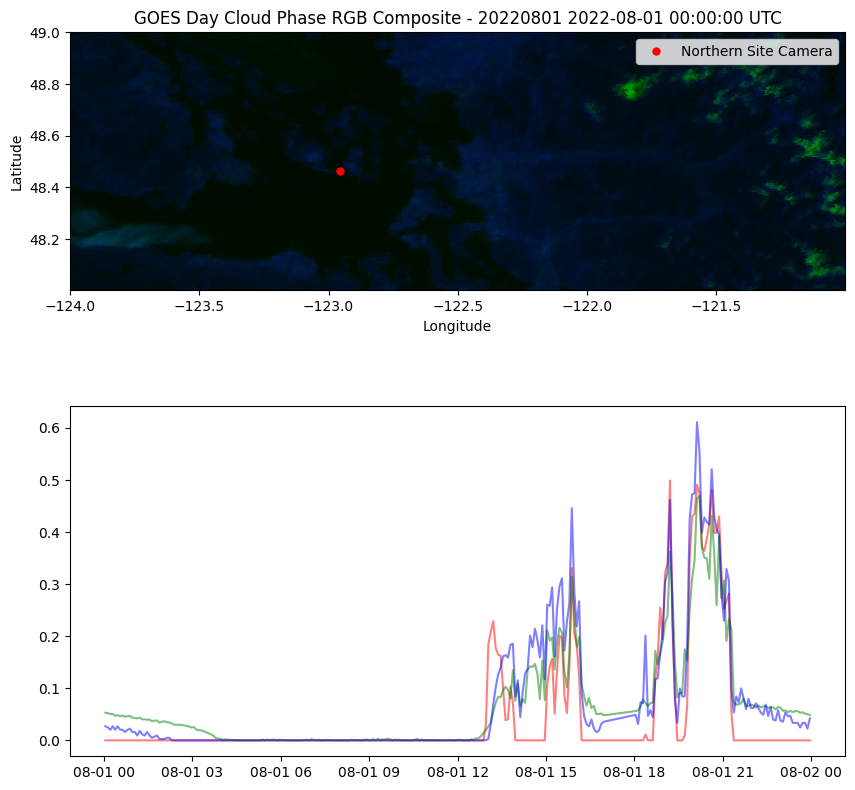

In [29]:
make_gif(ds, date)